# 1. Data loading

In [5]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import timedelta 
import sys
import os

sns.set_theme(style="whitegrid") 
%matplotlib inline

try: 
    sys.path.append(os.path.abspath(os.path.join('..', 'src')))
    from data_loader import FitFamDataLoader 
    print("Module data_loader importé avec succès.") 
except ImportError: print("ERREUR : Le fichier data_loader.py n'est pas trouvé dans le dossier.")

loader = FitFamDataLoader() 

unified_df = loader.get_unified_data()

unified_df['date'] = unified_df['start_time']

# Tri par utilisateur et date
unified_df = unified_df.sort_values(['user_id', 'date'])

print("Données chargées.")
print(f"Total lignes : {len(unified_df)}")
print(f"Total utilisateurs : {unified_df['user_id'].nunique()}")
print(f"Période : du {unified_df['date'].min()} au {unified_df['date'].max()}")

Module data_loader importé avec succès.
Données chargées.
Total lignes : 405861
Total utilisateurs : 21304
Période : du 2018-08-07 06:00:00 au 2025-03-22 10:00:00


# 2. Feature engineering 

In [6]:
# 1. Calcul de la "Date de début" pour chaque utilisateur
user_start = unified_df.groupby('user_id')['date'].min().reset_index()
user_start.columns = ['user_id', 'start_date']
df = unified_df.merge(user_start, on='user_id')

# Calcul de l'ancienneté (jours depuis le début)
df['days_since_start'] = (df['date'] - df['start_date']).dt.days

# 2. FILTRE COHORTE : On garde seulement les utilisateurs inscrits il y a > 90 jours
# Sinon on ne peut pas savoir s'ils sont restés 3 mois
max_date = df['date'].max()
cutoff_date = max_date - timedelta(days=90)
valid_users = user_start[user_start['start_date'] <= cutoff_date]['user_id']
df_cohort = df[df['user_id'].isin(valid_users)].copy()

print(f"Utilisateurs analysables (>90 jours d'ancienneté) : {df_cohort['user_id'].nunique()}")

# 3. VARIABLES EXPLICATIVES (X) : Activité des 14 premiers jours
# On isole les sessions qui ont eu lieu dans les 2 premières semaines
early_activity = df_cohort[df_cohort['days_since_start'] <= 14]

# A. Fréquence (Nombre de sessions total)
h1_data = early_activity.groupby('user_id').size().reset_index(name='frequency_14d')

# B. Régularité (Écart-type des jours entre les sessions)
# Note : Il faut au moins 3 sessions pour un écart-type fiable
def calculate_regularity(x):
    if len(x) < 3: return np.nan
    return x.diff().dt.days.std() # .dt.days pour convertir le timedelta en nombre

regularity = early_activity.groupby('user_id')['date'].agg(calculate_regularity).reset_index(name='regularity_std_14d')
h1_data = h1_data.merge(regularity, on='user_id', how='left')

# 4. VARIABLE CIBLE (Y) : Rétention
# Est-ce que l'utilisateur est revenu au moins une fois APRES 90 jours ?
active_after_90d = df_cohort[df_cohort['days_since_start'] > 90]['user_id'].unique()
h1_data['is_retained_3m'] = h1_data['user_id'].isin(active_after_90d).astype(int)

print("Tableau final prêt (aperçu) :")
display(h1_data.head())

Utilisateurs analysables (>90 jours d'ancienneté) : 21016
Tableau final prêt (aperçu) :


,user_id,frequency_14d,regularity_std_14d,is_retained_3m
0,1,10,1.563472,0
1,2,3,0.707107,1
2,3,5,1.258306,1
3,4,7,1.751190,1
4,5,6,1.732051,1


# 3. visualisation et preuve

C:\Users\gaspa\AppData\Local\Temp\ipykernel_105488\113743374.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_retained_3m', y='frequency_14d', data=h1_data, palette="Set2")
C:\Users\gaspa\AppData\Local\Temp\ipykernel_105488\113743374.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='is_retained_3m', y='regularity_std_14d', data=h1_data, palette="Set2")


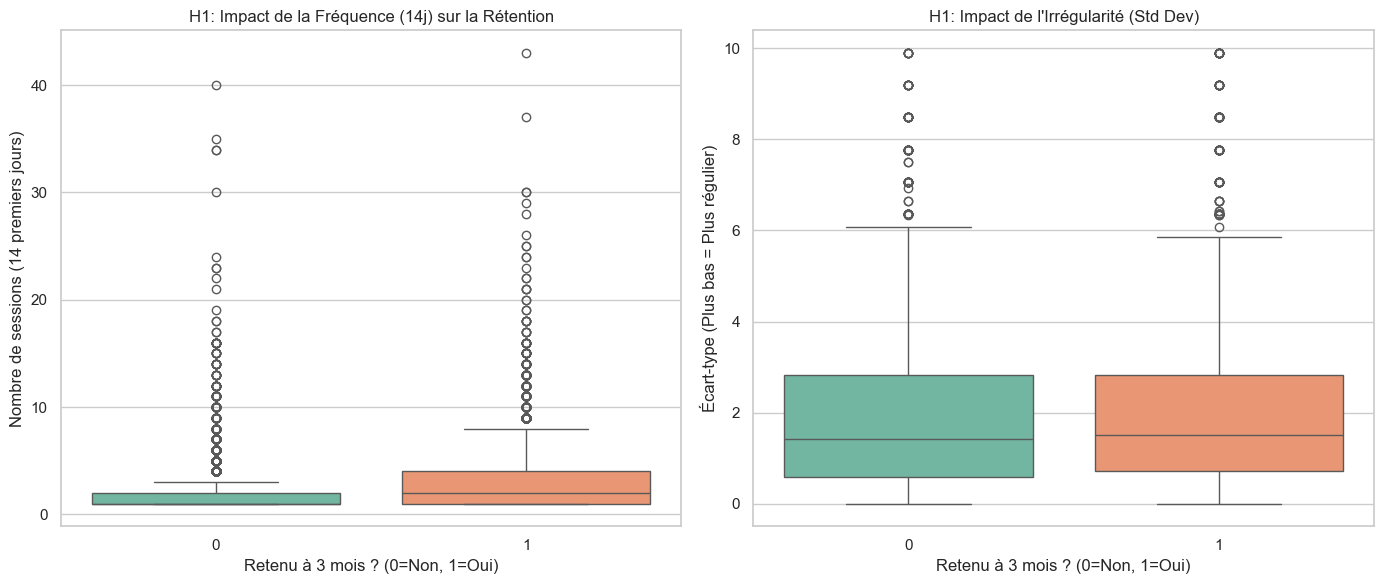

--- RÉSULTATS MOYENS ---


,frequency_14d,regularity_std_14d
is_retained_3m,,
0,1.685244,1.896950
1,3.006601,1.961133


In [7]:
plt.figure(figsize=(14, 6))

# Boxplot Fréquence
plt.subplot(1, 2, 1)
sns.boxplot(x='is_retained_3m', y='frequency_14d', data=h1_data, palette="Set2")
plt.title("H1: Impact de la Fréquence (14j) sur la Rétention")
plt.xlabel("Retenu à 3 mois ? (0=Non, 1=Oui)")
plt.ylabel("Nombre de sessions (14 premiers jours)")

# Boxplot Régularité
plt.subplot(1, 2, 2)
sns.boxplot(x='is_retained_3m', y='regularity_std_14d', data=h1_data, palette="Set2")
plt.title("H1: Impact de l'Irrégularité (Std Dev)")
plt.xlabel("Retenu à 3 mois ? (0=Non, 1=Oui)")
plt.ylabel("Écart-type (Plus bas = Plus régulier)")

plt.tight_layout()
plt.show()

# Moyennes chiffrées pour le rapport
stats = h1_data.groupby('is_retained_3m')[['frequency_14d', 'regularity_std_14d']].mean()
print("--- RÉSULTATS MOYENS ---")
display(stats)

# 4. Validation

In [9]:
from scipy.stats import mannwhitneyu

# 1. Test sur la Fréquence
# On compare le groupe "Retenu" vs "Non Retenu"
group_retained = h1_data[h1_data['is_retained_3m'] == 1]['frequency_14d']
group_churned = h1_data[h1_data['is_retained_3m'] == 0]['frequency_14d']

# On utilise Mann-Whitney U car vos données ne suivent probablement pas une loi normale parfaite
stat, p_value_freq = mannwhitneyu(group_retained, group_churned, alternative='greater')

print(f"1. Fréquence : Les retenus viennent-ils plus souvent ?")
print(f"   P-value = {p_value_freq:.5f}")
if p_value_freq < 0.05:
    print("   -> RÉSULTAT SIGNIFICATIF : Oui, la différence est réelle (p < 0.05).")
else:
    print("   -> Résultat non significatif (peut être dû au hasard).")

print("-" * 30)

# 2. Test sur la Régularité (pour ceux qui ont > 2 sessions)
# Rappel : Pour la régularité (écart-type), "Mieux" veut dire "Plus petit" (less)
valid_reg = h1_data.dropna(subset=['regularity_std_14d'])
group_retained_reg = valid_reg[valid_reg['is_retained_3m'] == 1]['regularity_std_14d']
group_churned_reg = valid_reg[valid_reg['is_retained_3m'] == 0]['regularity_std_14d']

stat, p_value_reg = mannwhitneyu(group_retained_reg, group_churned_reg, alternative='less')

print(f"2. Régularité : Les retenus sont-ils plus réguliers (écart-type plus faible) ?")
print(f"   P-value = {p_value_reg:.5f}")
if p_value_reg < 0.05:
    print("   -> RÉSULTAT SIGNIFICATIF : Oui, la régularité prédit la rétention.")
else:
    print("   -> Résultat non significatif.")

1. Fréquence : Les retenus viennent-ils plus souvent ?
   P-value = 0.00000
   -> RÉSULTAT SIGNIFICATIF : Oui, la différence est réelle (p < 0.05).
------------------------------
2. Régularité : Les retenus sont-ils plus réguliers (écart-type plus faible) ?
   P-value = 0.99979
   -> Résultat non significatif.


# 5. Discussion des résultats

On cherchait à prouver que les clients fidèles avaient un écart-type plus faible (plus réguliers).

Une p-value de 0.99 avec l'option alternative='less' suggère que c'est l'inverse. Les clients fidèles ont souvent un écart-type plus élevé ou égal aux autres.

On peut donc penser qu'il est probable que les utilisateurs qui abandonnent ont un motif simple (par exemple ceux qui sont venus 3 fois d'affilée puis arrêt). Cela crée une fausse régularité mécanique.

À l'inverse, les clients qui restent testent peut-être différents cours à différents moments (comme lundi soir puis samedi matin), ce qui augmente leur irrégularité mathématique, mais montre une meilleure exploration de l'offre.